In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 
import random
from PIL import Image

In [ ]:
def loadVid(path):
	# Create a VideoCapture object and read from input file
	# If the input is the camera, pass 0 instead of the video file name
	cap = cv2.VideoCapture(path)
	 
	# Check if camera opened successfully
	if (cap.isOpened()== False): 
		print("Error opening video stream or file")

	i = 0
	# Read until video is completed
	while(cap.isOpened()):
		# Capture frame-by-frame
		i += 1
		ret, frame = cap.read()
		if ret == True:

			#Store the resulting frame
			if i == 1:
				frames = frame[np.newaxis, ...]
			else:
				frame = frame[np.newaxis, ...]
				frames = np.vstack([frames, frame])
				frames = np.squeeze(frames)
			
		else: 
			break
	 
	# When everything done, release the video capture object
	cap.release()

	return frames

In [ ]:
frames = loadVid("/content/book.mov")

In [ ]:
book_img  = cv2.imread("/content/cv_cover.jpg")

In [ ]:
frames2 = loadVid("/content/ar_source.mov")

In [ ]:
frames_0 = frames[0]
frames_0_RGB = cv2.cvtColor(frames_0, cv2.COLOR_BGR2RGB)

In [ ]:
frames2_0 = frames2[0]
frames2_0_RGB = cv2.cvtColor(frames2_0, cv2.COLOR_BGR2RGB)

### **1.1**

In [ ]:
def Get_correspondences(img1,img2):
  #sift
  sift = cv2.SIFT_create()

  keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
  keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

  #feature matching
  matches = cv2.BFMatcher().knnMatch(descriptors_1, descriptors_2, k=2)

  # Apply ratio test
  good = []
  for m,n in matches:
      if m.distance < 0.75*n.distance:
          good.append([m])
  
  #sorting good matches by distance
  good = sorted(good, key = lambda x:x[0].distance)

  return good, keypoints_1, keypoints_2,img1,img2

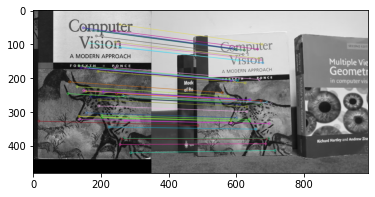

In [ ]:
img1_gray = cv2.cvtColor(book_img, cv2.COLOR_RGB2GRAY)
img2_gray = cv2.cvtColor(frames_0, cv2.COLOR_BGR2GRAY)
good,keypoints_1,keypoints_2,img1,img2 = Get_correspondences(img1_gray,img2_gray)
img3 = cv2.drawMatchesKnn(img1_gray,keypoints_1,img2_gray,keypoints_2,good[:50],None,flags=2)
plt.imshow(img3)
plt.show()

### **1.2**

In [ ]:
def Generate_match_points(good):
  match_points = []
  for match in good:
    (x1, y1) = keypoints_1[match[0].queryIdx].pt
    (x2, y2) = keypoints_2[match[0].trainIdx].pt
    match_points.append([x1, y1, x2, y2])
  match_points = np.matrix(match_points)
  return match_points

In [ ]:
match_points = Generate_match_points(good)

In [ ]:
def Distance(match_point, h):
    p1 = np.transpose(np.matrix([match_point.item(0), match_point.item(1), 1]))
    ep2 = np.dot(h, p1)
    ep2 = (1/ep2.item(2))*ep2
    p2 = np.transpose(np.matrix([match_point.item(2), match_point.item(3), 1]))
    return np.linalg.norm(p2 - ep2)

def Homography_CAL(four_points):
    AList = []
    for point in four_points:
        x1 = point.item(0)
        y1 = point.item(1)
        x2 = point.item(2)
        y2 = point.item(3)
        a2 = [0, 0, 0, -x1, -y1, -1, y2*x1, y2*y1, y2]
        a1 = [-x1, -y1, -1, 0, 0, 0, x2*x1, x2*y1, x2]
        AList.append(a1)
        AList.append(a2)
    Amatrix = np.matrix(AList)
    u, s, v = np.linalg.svd(Amatrix)
    h = np.reshape(v[8], (3, 3))
    h = (1/h.item(8)) * h

    return h

def Best_Homography(match_points):
    MaxInliers = []
    Hfinal = None
    for i in range(50):
        four_rand = []
        p1 = np.array(match_points[random.randrange(0, len(match_points))])
        #print(p1)
        p2 =  np.array(match_points[random.randrange(0, len(match_points))])
        four_rand = np.concatenate((p1, p2), axis=0)
        p3 =  np.array(match_points[random.randrange(0, len(match_points))])
        four_rand = np.concatenate((four_rand, p3), axis=0)
        p4 =  np.array(match_points[random.randrange(0, len(match_points))])
        four_rand = np.concatenate((four_rand, p4), axis=0)
        #print(four_rand)
        h = Homography_CAL(four_rand)
        inliers = []
        for i in range(len(match_points)):
            dis = Distance(match_points[i][0], h)
            if dis < 5:
                inliers.append(match_points[i])
        if len(inliers) > len(MaxInliers):
            MaxInliers = inliers
            Hfinal = h
            temp = four_rand
    return Hfinal,temp

In [ ]:
Hfinal,points = Best_Homography(match_points)
Hfinal

matrix([[ 8.98192349e-01, -2.66979100e-03, -2.00696546e+01],
        [ 8.96711712e-03,  8.33023727e-01,  6.41310461e+01],
        [ 9.85319044e-05, -7.32645126e-05,  1.00000000e+00]])

In [ ]:
actual_h2, status = cv2.findHomography(points[:,:2], points[:,2:])
print("actual homography\n",actual_h2)

actual homography
 [[ 8.98192349e-01 -2.66979100e-03 -2.00696546e+01]
 [ 8.96711712e-03  8.33023727e-01  6.41310461e+01]
 [ 9.85319044e-05 -7.32645126e-05  1.00000000e+00]]


### **1.3**

In [ ]:
def Generate_coordinates(perspectiveMatrix, sourcePoints):
    '''
    perspectiveMatrix 3x3
    sourcePoints has shape (n,2)
    '''

    # first we extend source points by a column of 1
    # augment has shape (n,1)
    augment = np.ones((sourcePoints.shape[0],1))
    # projective_corners is a 3xn matrix with last row all 1
    # note that we transpose the concatenation
    projective_corners = np.concatenate( (sourcePoints, augment), axis=1).T

    # projective_points has shape 3xn
    projective_points = np.dot(perspectiveMatrix,projective_corners)

    # obtain the target_points by dividing the projective_points 
    # by its last row (where it is non-zero)
    # target_points has shape (3,n).
    target_points = np.divide(projective_points, projective_points[-1])

    # so we want return points in row form
    return target_points[:2].T

### **1.4**

In [ ]:
def resize_ar_source(book_coords,ar_frame,width,hight):
  ar_frame=ar_frame[45:315,int(book_coords[0][0]+120):int(book_coords[2][0])+200]
  print(width)
  print(hight)
  ar_frame = cv2.resize(ar_frame, ((width),(hight)))
  return ar_frame

# **1.5**

In [ ]:
def overlay(book_frame,resized_ar_frame,A):
  img1 = Image.fromarray(book_frame)
  img2 = Image.fromarray(resized_ar_frame)
  img1.paste(img2, (int(A[0][0])-10,int(A[0][1]-20)))
  return img1

# **1.6**

In [ ]:
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('ar_result.avi', fourcc, 15, (frames.shape[0], frames.shape[1]))

In [ ]:
for i in range(len(frames2)):
  print('processing {}th img.....'.format(i))
  #Getting correspondence
  img1_gray = cv2.cvtColor(book_img, cv2.COLOR_RGB2GRAY)
  img2_gray = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
  good,keypoints_1,keypoints_2,img1,img2 = Get_correspondences(img1_gray,img2_gray)

  #Compute the homography parameters
  match_points = Generate_match_points(good)
  Hfinal,points = Best_Homography(match_points)

  #calculate book coordinates
  h , w ,_ = book_img.shape
  pts2 = np.float32([[0,0],[0,h-1],[w-1,h-1],[w-1,0]])
  vid_book_coordinates = Generate_coordinates(Hfinal, pts2)

  #crop AR video frames
  A = np.squeeze(np.asarray(vid_book_coordinates))
  frames2_RGB = cv2.cvtColor(frames2[i], cv2.COLOR_BGR2RGB)
  if A[2][0] < 0 :
    A[2][0] = temp[2][0]
  elif A[0][0] < 0:
    A[0][0] = temp[0][0]
  elif A[1][0] < 0:
    A[1][0] = temp[1][0]
  elif A[3][1] < 0:
    A[3][1] = temp[3][1]
  #if i ==0:
  width = int(A[2][0]) - int(A[0][0])+10
  hight = int(A[1][1]) - int(A[3][1])+15
  resized_ar_frame = resize_ar_source(A,frames2_RGB,width,hight)

  #overlay
  #resized_ar_frame_RGB = cv2.cvtColor(resized_ar_frame, cv2.COLOR_BGR2RGB)
  frames_RGB = cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB)
  img = overlay(frames_RGB,resized_ar_frame,A)
  img = np.array(img)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  out.write(img)
  #plt.imshow(overlay(frames_RGB,resized_ar_frame_RGB,A))
  A = np.squeeze(np.asarray(vid_book_coordinates))
  temp = A



processing 0th img.....
309
385
processing 1th img.....
308
386
processing 2th img.....
308
385
processing 3th img.....
310
387
processing 4th img.....
309
388
processing 5th img.....
309
389
processing 6th img.....
308
386
processing 7th img.....
309
386
processing 8th img.....
308
389
processing 9th img.....
309
387
processing 10th img.....
307
387
processing 11th img.....
310
387
processing 12th img.....
308
386
processing 13th img.....
312
388
processing 14th img.....
307
379
processing 15th img.....
308
388
processing 16th img.....
309
388
processing 17th img.....
311
388
processing 18th img.....
308
387
processing 19th img.....
310
389
processing 20th img.....
310
390
processing 21th img.....
309
384
processing 22th img.....
310
390
processing 23th img.....
311
385
processing 24th img.....
308
386
processing 25th img.....
310
386
processing 26th img.....
309
390
processing 27th img.....
304
388
processing 28th img.....
309
387
processing 29th img.....
311
388
processing 30th img.